In [2]:
from PINNs import PINN, Geometry, Physics, NetworkTrainer, Visualizer, ProblemDomain
import torch
import matplotlib.pyplot as plt

In [3]:
area_big = Geometry.rectangle([0,5],[-0.5,0.5])

C:\Users\thamm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4324.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


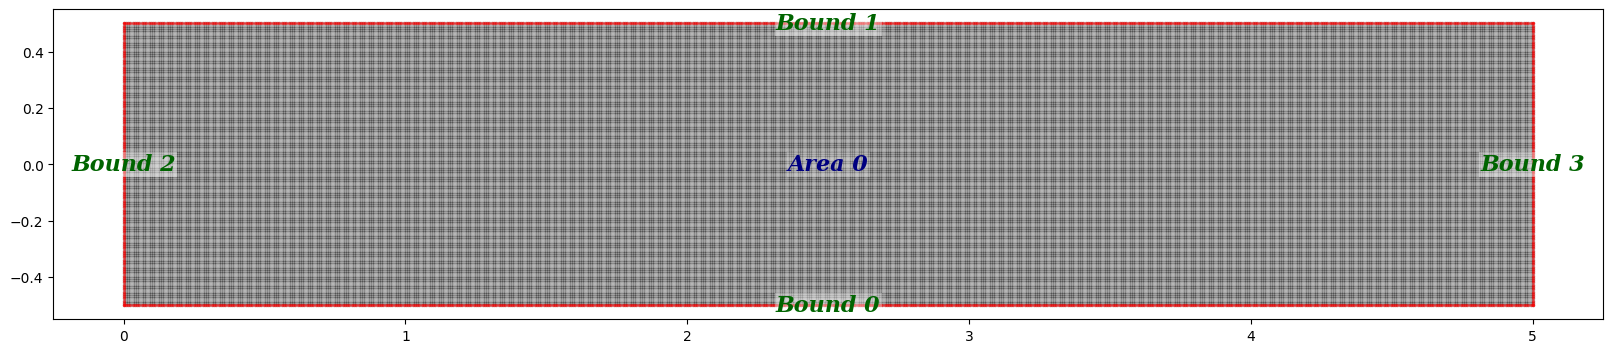

In [4]:
domain = ProblemDomain(area_big.bound_list,[area_big])
domain.show_setup()

## Define Physics

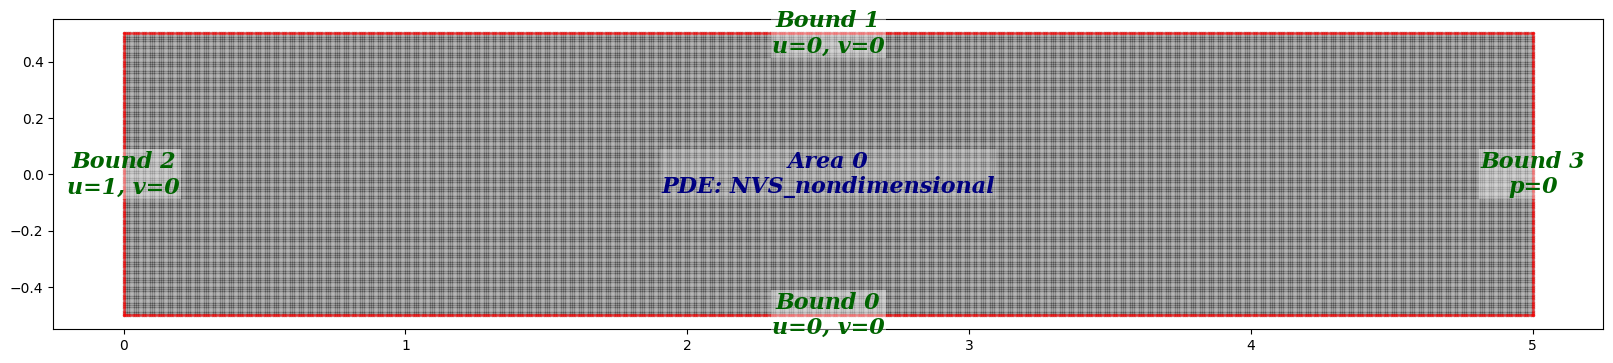

In [5]:
domain.bound_list[0].define_bc({'u':0,'v':0})
domain.bound_list[1].define_bc({'u':0,'v':0})
domain.bound_list[2].define_bc({'u': 1, 'v': 0})
domain.bound_list[3].define_bc({'p':0})
domain.area_list[0].define_pde(Physics.NVS_nondimensional(U=0.0001, L=1, mu=0.001, rho=1000))
domain.show_setup()

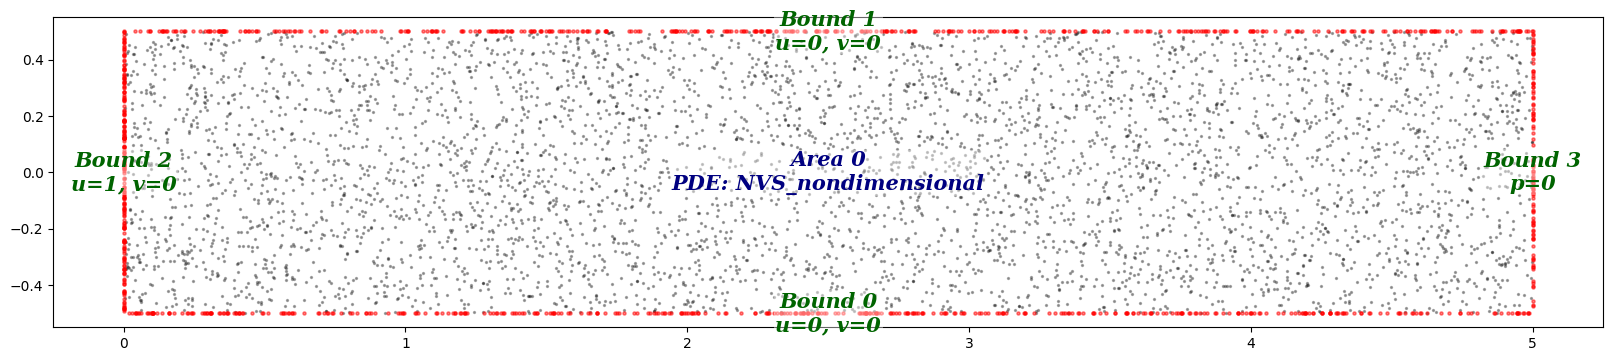

In [5]:
domain.sampling_random_r([400, 400, 200, 100], [5000], device='cuda')
domain.show_coordinates()

In [6]:
model0 = PINN(width=40, length=8).to('cuda')
loss_fn = torch.nn.MSELoss()
n = 0

In [7]:
# Define the loss calculation function
def calc_loss(model):
    global n
    # Re-sample the collocation points
    # if n % 50 == 0 or n == 0:
    #     domain.sampling_random_r([800, 800, 400, 200], [1000], device='cuda')
    n += 1
    if n%1000==0:
        domain.sampling_RAR([80, 80, 40, 20], [1000], model, [400, 400, 200, 100],[5000], device='cuda')
    
    # BC Loss
    bc_loss = 0.0
    for i, bc in enumerate(domain.bound_list):
        bc_loss += bc.calc_loss(model, loss_fn) #lambda pred, true: ((pred - true)**2/true).mean())

    # PDE Loss
    pde_loss = 0.0
    for i, area in enumerate(domain.area_list):
        pde_loss += area.calc_loss(model, loss_fn)

    # Total Loss
    total_loss = bc_loss + pde_loss

    return {"bc_loss": bc_loss, "pde_loss": pde_loss, "total_loss": total_loss}

In [8]:
# Train the model
model1 = NetworkTrainer.train_adam(
    model=model0,
    calc_loss=calc_loss,
    learning_rate=0.0004,
    epochs=5000,
    print_every=250,
    thereshold_loss=0.005
)

epoch 1, total_loss: 1.37601, bc_loss: 1.37598, pde_loss: 0.00002


KeyboardInterrupt: 

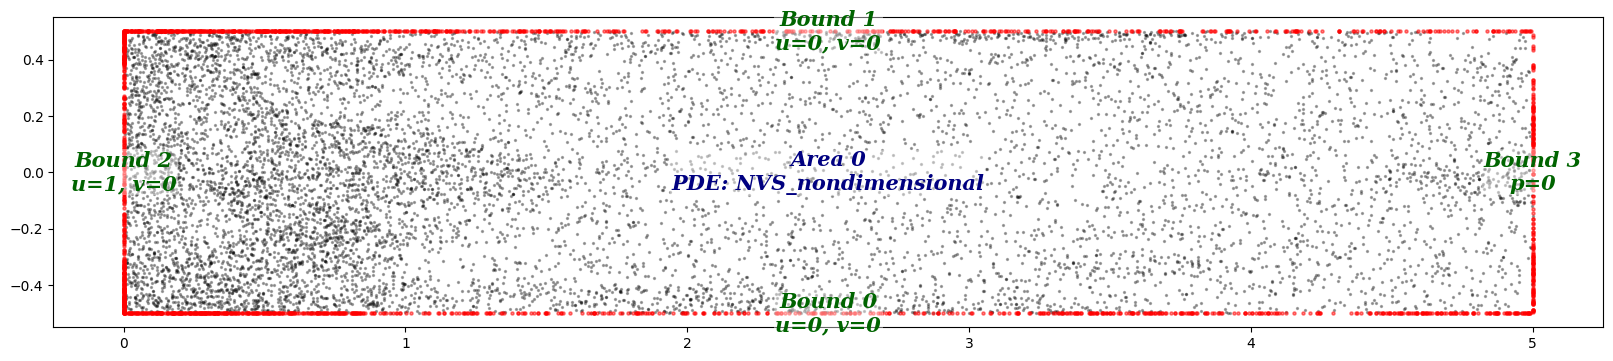

number of bound : 4
        ['0: 800', '1: 800', '2: 400', '3: 200']
        , number of area : 1
        ['0: 10000']


In [ ]:
domain.show_coordinates()
print(domain)

In [ ]:
x = Geometry.rectangle([0.05,4.95],[-0.495,0.495])
x.define_pde(Physics.NVS_nondimensional(U=0.0001, L=1, mu=0.001, rho=1000))

In [ ]:
# Create visualization object
area_visual = Visualizer(model1, x)
area_visual.sampling_area([500,100])
keyword = area_visual.preprocess()

available_data: ('u', 'v', 'p', 'velocity_magnitude', 'PDE residual', 'total_loss', 'bc_loss', 'pde_loss')


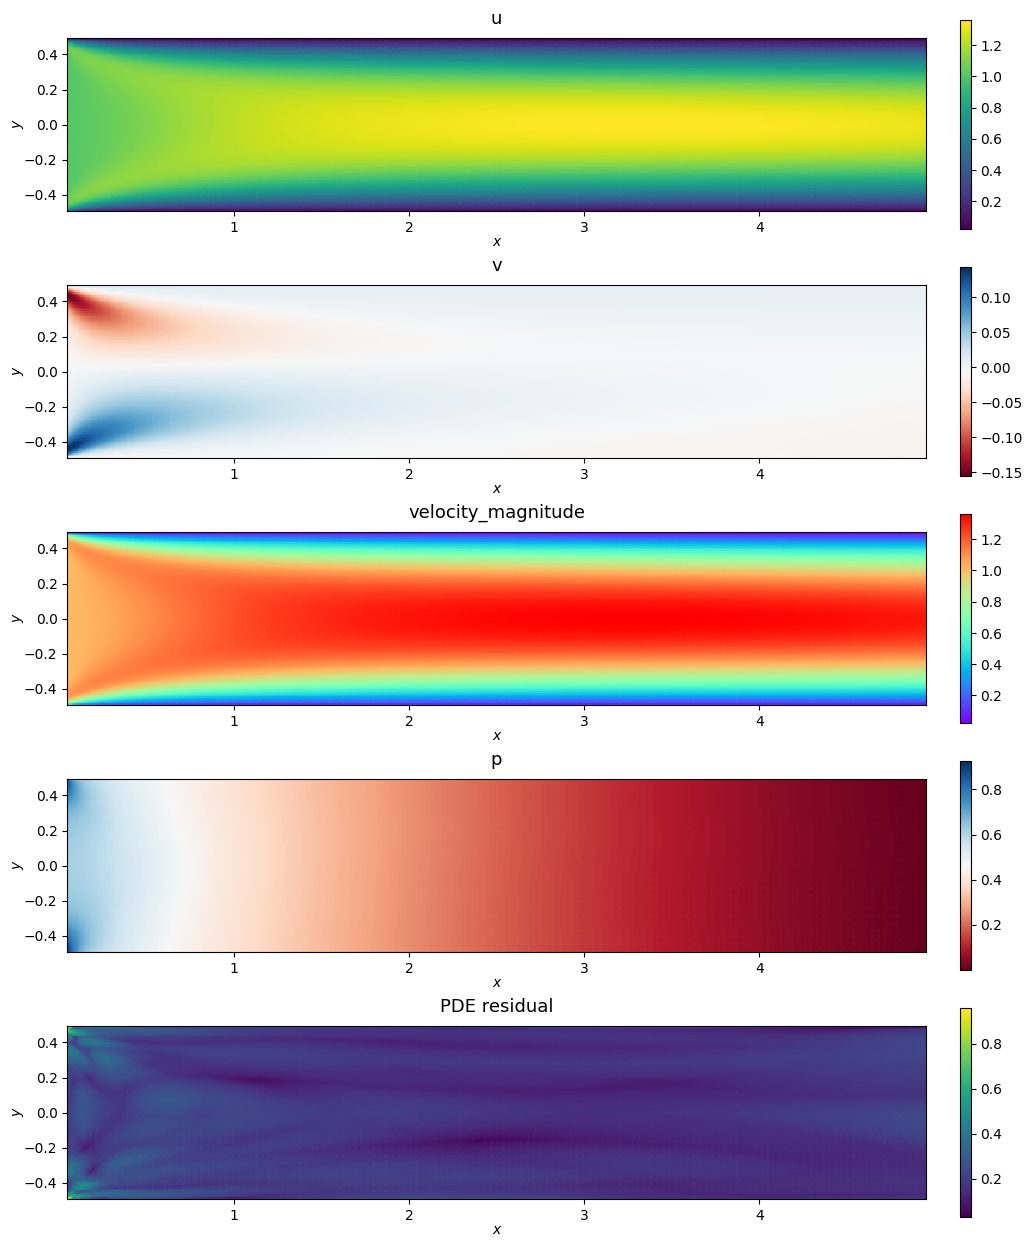

In [ ]:
cmap_dict = {
    'u':None,
    'v':'RdBu',
    'velocity_magnitude': 'rainbow',
    'p':'RdBu',
    'PDE residual': 'viridis'
}
colorplot_all = area_visual.plot_data_on_geometry(cmap_dict, s=1)
colorplot_all.savefig('cylinder_flow_steady_all.png')

In [ ]:
# Create visualization object
bound_visual = Visualizer(model1, domain.bound_list[3])
bound_visual.sampling_line(100)
bound_visual.preprocess()

available_data: ('u', 'v', 'p', 'velocity_magnitude', 'BC residual', 'total_loss', 'bc_loss', 'pde_loss')


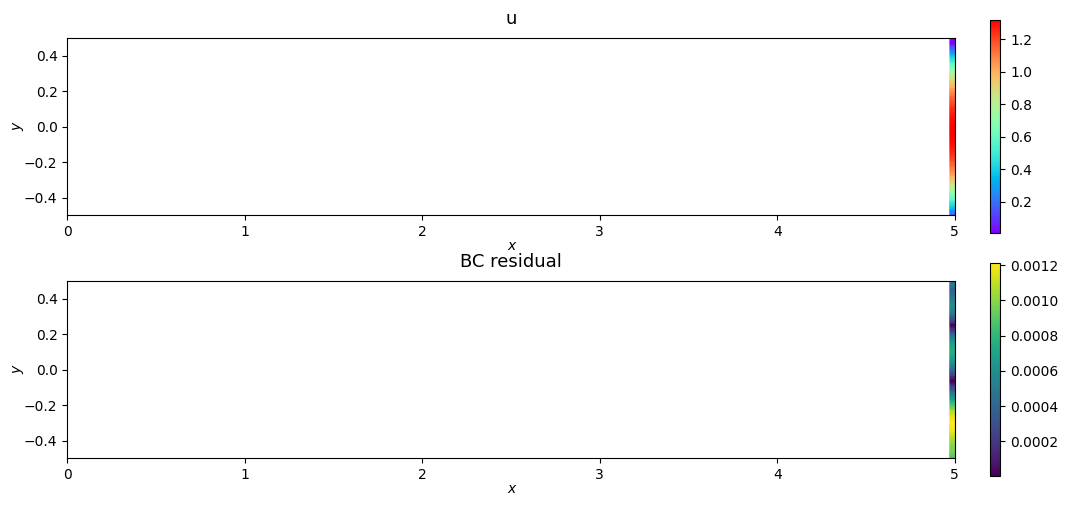

In [ ]:
plot = bound_visual.plot_data_on_geometry({'u':'rainbow','BC residual':None}, range_x=[0,5], range_y=[-0.5,0.5], s=50)

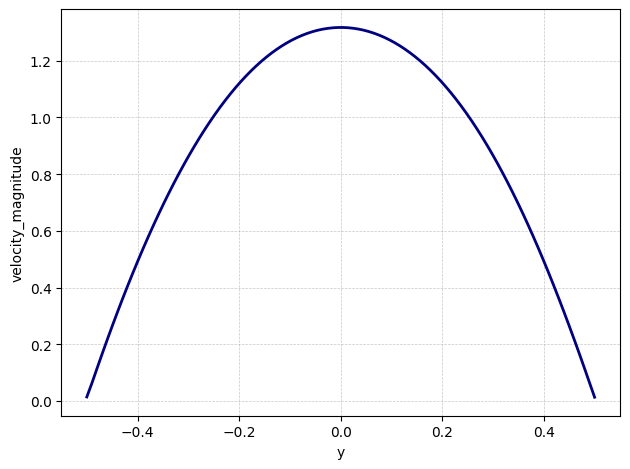

In [ ]:
plot = bound_visual.plot_data(['velocity_magnitude'])

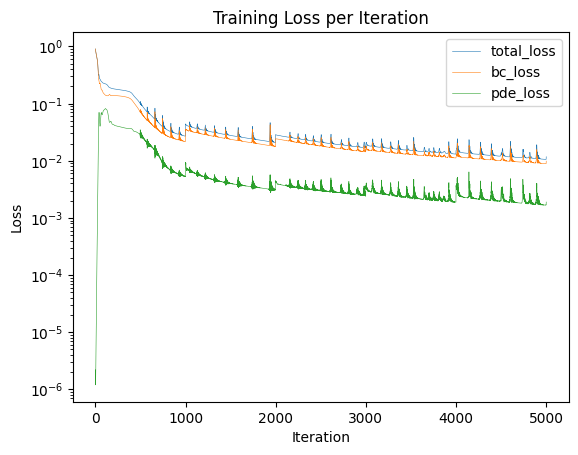

In [ ]:
a = bound_visual.plot_loss_evolution(log_scale=True, linewidth=0.4)

In [ ]:
import pickle

# Save model with pickle
with open("model.pkl", "wb") as f:
    pickle.dump(model1, f)


In [ ]:
# # Load model back
# with open("model.pkl", "rb") as f:
#     model1 = pickle.load(f)

In [ ]:
import numpy as np
data = np.loadtxt("laminar flow data.txt", delimiter=",", skiprows=1)

<Axes: xlabel='x', ylabel='y'>

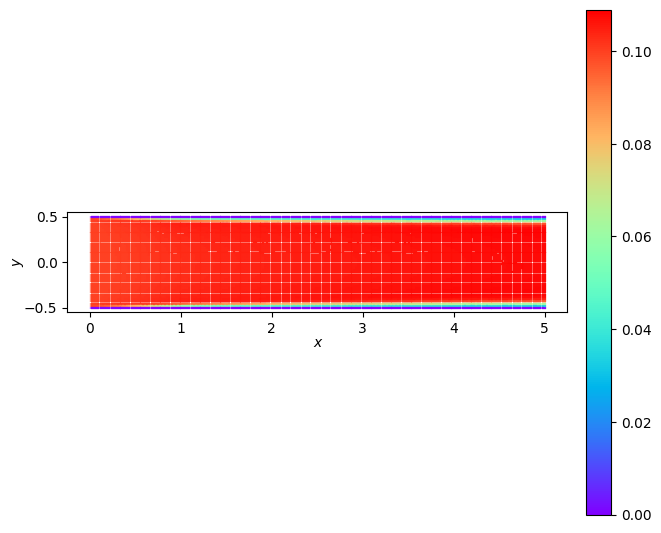

In [ ]:
fig, ax = plt.subplots()

X = data[:,1]
Y = data[:,2]
Pressure = data[:,3]
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
Visualizer.colorplot(X, Y, Pressure, ax, s=0.4, cmap='rainbow')
